In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger données de consommation
df_load = pd.read_csv("../data/profil_charge_tertiaire.csv")
df_load["datetime"] = pd.to_datetime(df_load["datetime"])
df_load.set_index("datetime", inplace=True)

# Charger données de production PV
df_pv = pd.read_csv("../data/pv_simulation.csv")
df_pv["datetime"] = pd.to_datetime(df_pv["datetime"])
df_pv.set_index("datetime", inplace=True)

df_load.head(), df_pv.head()
print("Nombre de lignes : ", len(df_load), "Nombre de lignes : ", len(df_pv))



Nombre de lignes :  8760 Nombre de lignes :  8760


In [22]:
df = df_load.join(df_pv, how="inner") # Fusionne les deux DataFrames sur la base de l'index datetime, en conservant uniquement les lignes où les deux DataFrames ont des données (inner join)
df.head()

,power_kW,pv_kW
datetime,,
2023-01-01 00:00:00+00:00,53.882739,0.0
2023-01-01 01:00:00+00:00,38.719457,0.0
2023-01-01 02:00:00+00:00,53.568610,0.0
2023-01-01 03:00:00+00:00,68.411728,0.0
2023-01-01 04:00:00+00:00,0.000000,0.0


In [23]:
# Autoconsommation instantanée
df["autoconsommation_kW"] = df[["power_kW", "pv_kW"]].min(axis=1)

# Injection dans le réseau
df["injection_kW"] = (df["pv_kW"] - df["autoconsommation_kW"]).clip(lower=0) # Valeur minimum à 0 pour éviter les valeurs négatives

#Soutirage du réseau
df["soutirage_kW"] = (df["power_kW"] - df["autoconsommation_kW"]).clip(lower=0)

df.head()

,power_kW,pv_kW,autoconsommation_kW,injection_kW,soutirage_kW
datetime,,,,,
2023-01-01 00:00:00+00:00,53.882739,0.0,0.0,0.0,53.882739
2023-01-01 01:00:00+00:00,38.719457,0.0,0.0,0.0,38.719457
2023-01-01 02:00:00+00:00,53.568610,0.0,0.0,0.0,53.568610
2023-01-01 03:00:00+00:00,68.411728,0.0,0.0,0.0,68.411728
2023-01-01 04:00:00+00:00,0.000000,0.0,0.0,0.0,0.000000


In [24]:
annual_load = df["power_kW"].sum()
annual_pv = df["pv_kW"].sum()
autoconsommation = df["autoconsommation_kW"].sum()
injection = df["injection_kW"].sum()
soutirage = df["soutirage_kW"].sum()

taux_autoconsommation = autoconsommation / annual_pv
taux_autosuffisance = autoconsommation / annual_load

print(f"Consommation annuelle : {annual_load:.2f} kWh")
print(f"Production PV annuelle : {annual_pv:.2f} kWh")
print(f"Autoconsommation annuelle : {autoconsommation:.2f} kWh")
print(f"Injection annuelle : {injection:.2f} kWh")
print(f"Soutirage annuel : {soutirage:.2f} kWh")
print(f"Taux d'autoconsommation : {taux_autoconsommation:.2%}")
print(f"Taux d'autosuffisance : {taux_autosuffisance:.2%}")

Consommation annuelle : 2192045.12 kWh
Production PV annuelle : 693489.06 kWh
Autoconsommation annuelle : 681454.19 kWh
Injection annuelle : 12034.87 kWh
Soutirage annuel : 1510590.94 kWh
Taux d'autoconsommation : 98.26%
Taux d'autosuffisance : 31.09%


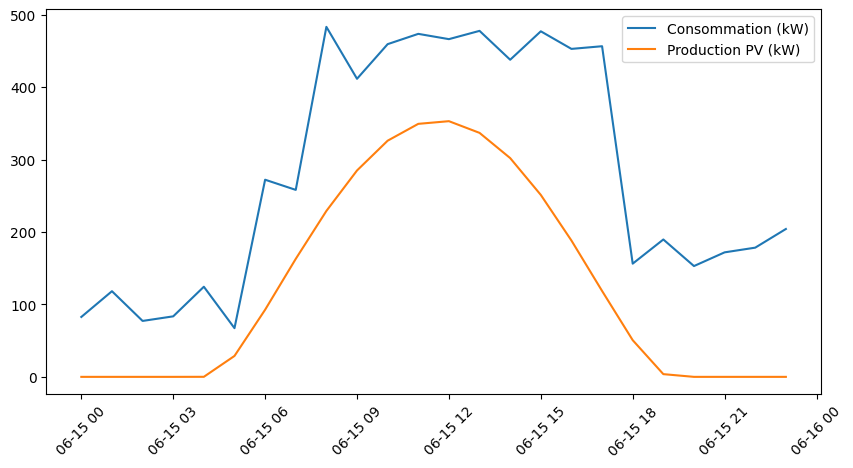

In [25]:
df_day = df.loc["2023-06-15"]

plt.figure(figsize=(10, 5))
plt.plot(df_day.index, df_day['power_kW'], label="Consommation (kW)")
plt.plot(df_day.index, df_day['pv_kW'], label="Production PV (kW)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

df.to_csv("../data/donnees_fusionnees.csv", index = True)